In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score
from sklearn.preprocessing import MinMaxScaler
import math
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

# グラフ設定
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# データの読み込み
df = pd.read_csv(r"C:\Users\Take\python\ntt-stock-prediction_test\data\features.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# 重要な特徴量の選択
important_features = [
    "Close","Open","High","Low","Volume",
    "Return_Lag_1","Return_Lag_2","Return_Lag_3","Return_Lag_5","Return_Lag_10",
    "MA_5_Slope","MA_10_Slope","MA_50_Slope","MA_100_Slope","MA_200_Slope",
    "Range_Ratio","ATR_Ratio","Volatility_50d",
    "Momentum_Vol_50d","Volume_Change","OBV_Change",
    "Gap","Return_Kurt_5d","Return_Skew_5d",
    "MA_Ratio_10","EMA_Ratio_20","Momentum_5d",
]

# 利用可能な特徴量のみを選択
available_features = [col for col in important_features if col in df.columns]
print(f"使用する特徴量: {available_features}")

# ターゲット変数と特徴量を準備
target_col = 'Close'
feature_cols = [col for col in available_features if col != target_col]

# 特徴量とターゲットを分離
X_raw = df[feature_cols].values
y_raw = df[target_col].values

# === 特徴量のスケーリング（LSTM対応：MinMaxScaler） ===
scaler_X = MinMaxScaler()
n_features = X_raw.shape[1]

# スケーリングのために2次元にreshape（全サンプルでfitさせるので時系列情報はまだ使わない）
X_scaled = scaler_X.fit_transform(X_raw)

# 元の形状に戻す準備（後でcreate_sequencesで時系列化）
y = y_raw.copy()  # yは後でscaler_yでスケーリング
X = X_scaled.copy()

# 時系列データの準備関数
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# シーケンス長の設定
SEQ_LENGTH = 30

# シーケンスデータの作成
X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)
print(f"シーケンスデータの形状: X={X_seq.shape}, y={y_seq.shape}")

# 訓練/テスト分割（時系列順）
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# === yのスケーリング ===
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"訓練データ: {X_train.shape}, {y_train_scaled.shape}")
print(f"テストデータ: {X_test.shape}, {y_test_scaled.shape}")

# モデル読み込み
model = load_model(r"C:\Users\Take\python\ntt-stock-prediction_test\notebooks\lstm_stock_model.h5")
print("モデルを読み込みました")
print(f"モデル入力形状: {model.input_shape}")
print(f"テストデータ形状: {X_test.shape}")

# モデル評価
loss = model.evaluate(X_test, y_test_scaled, verbose=0)
print(f"テスト損失: {loss:.4f}")

# 予測（スケーリングされた値）
y_pred_scaled = model.predict(X_test, verbose=0).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# 評価指標
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("\n===== モデル評価指標 =====")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# ----------- 以下の分析・可視化コードはそのままでOK -----------
# test_dates の調整
test_dates = df['Date'].iloc[-len(y_test):].reset_index(drop=True)

# 可視化・分析部分（省略せず元コード通り実行）

#（※ここに、上の可視化・分析・レポート部分を続けてください。基本的に修正は不要）


使用する特徴量: ['Close', 'Open', 'High', 'Low', 'Volume', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_5', 'Return_Lag_10', 'MA_5_Slope', 'MA_10_Slope', 'MA_50_Slope', 'MA_100_Slope', 'MA_200_Slope', 'Range_Ratio', 'ATR_Ratio', 'Volatility_50d', 'Momentum_Vol_50d', 'Volume_Change', 'OBV_Change', 'Gap', 'Return_Kurt_5d', 'Return_Skew_5d', 'MA_Ratio_10', 'EMA_Ratio_20', 'Momentum_5d']


シーケンスデータの形状: X=(8621, 365, 26), y=(8621,)
訓練データ: (6896, 365, 26), (6896,)
テストデータ: (1725, 365, 26), (1725,)
モデルを読み込みました
モデル入力形状: (None, 30, 26)
テストデータ形状: (1725, 365, 26)
テスト損失: 0.0933

===== モデル評価指標 =====
RMSE: 47.96
MAE: 41.37
MAPE: 30.54%
R²: -1.8286


In [56]:
np.std(y_pred)

4.273543

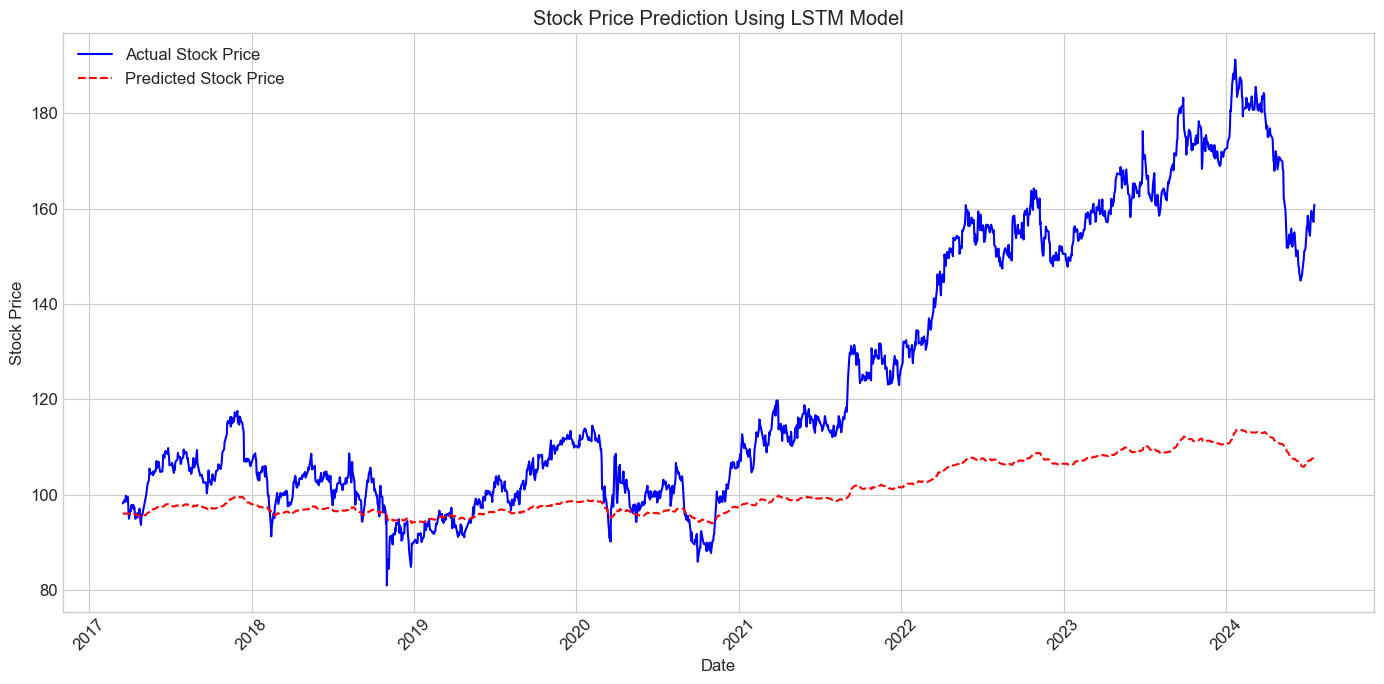

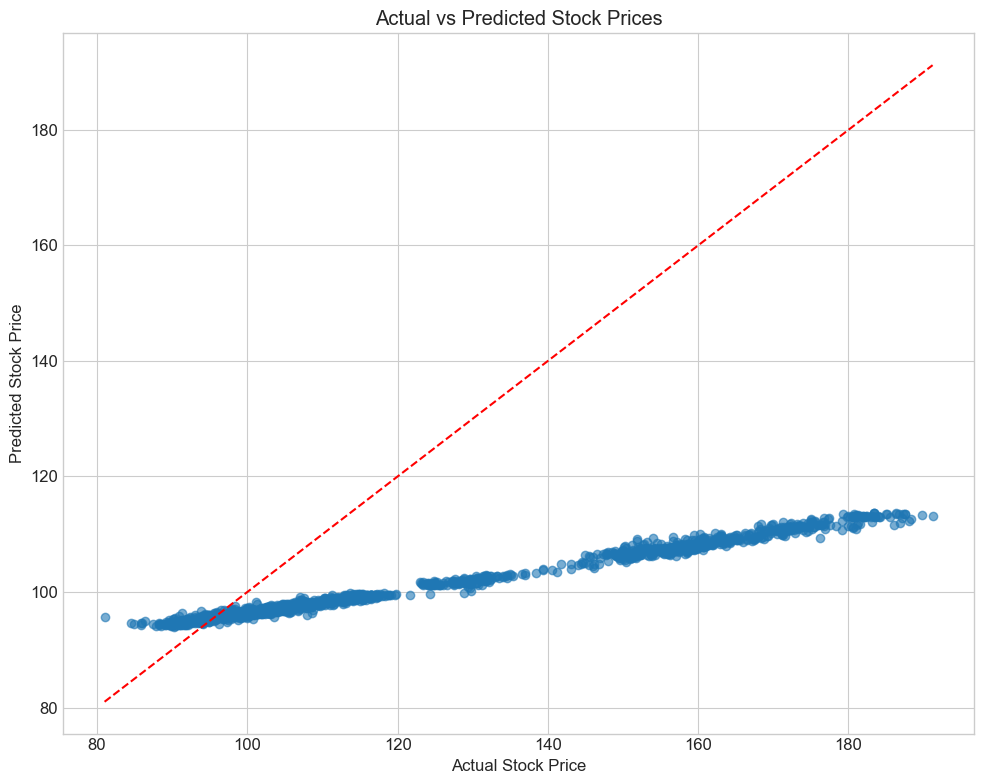

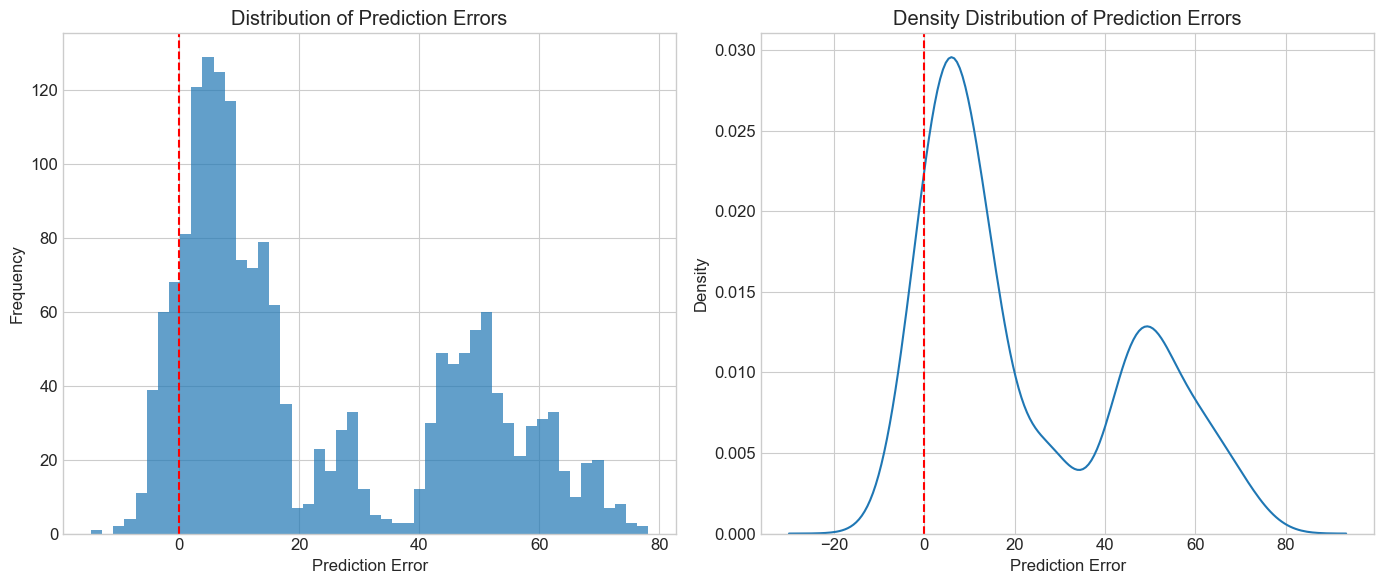

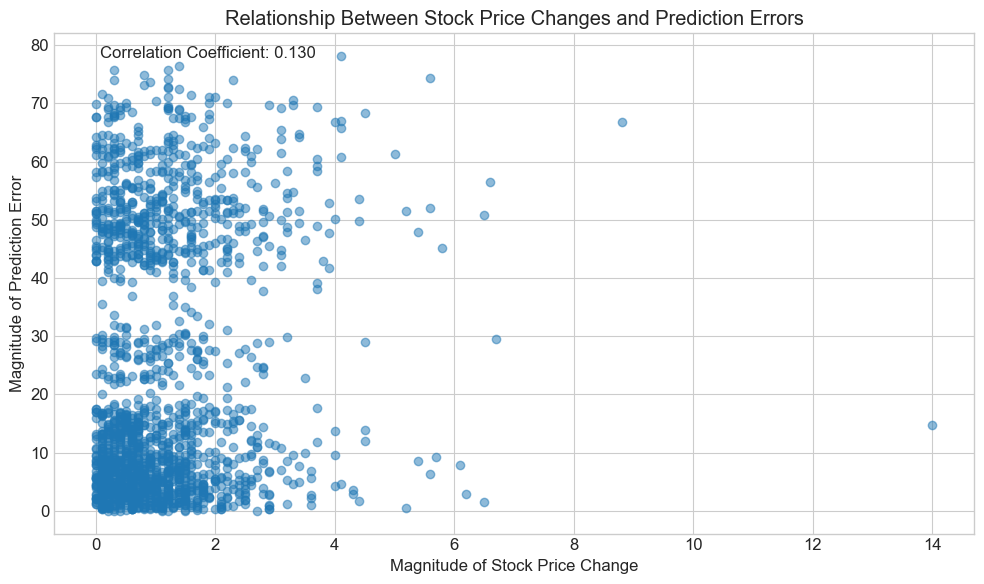


===== トレンド別の予測精度 =====
上昇日の予測誤差:
件数: 876
平均: 23.01
標準偏差: 22.60
RMSE: 32.25

下降日の予測誤差:
件数: 845
平均: 22.58
標準偏差: 22.72
RMSE: 32.03


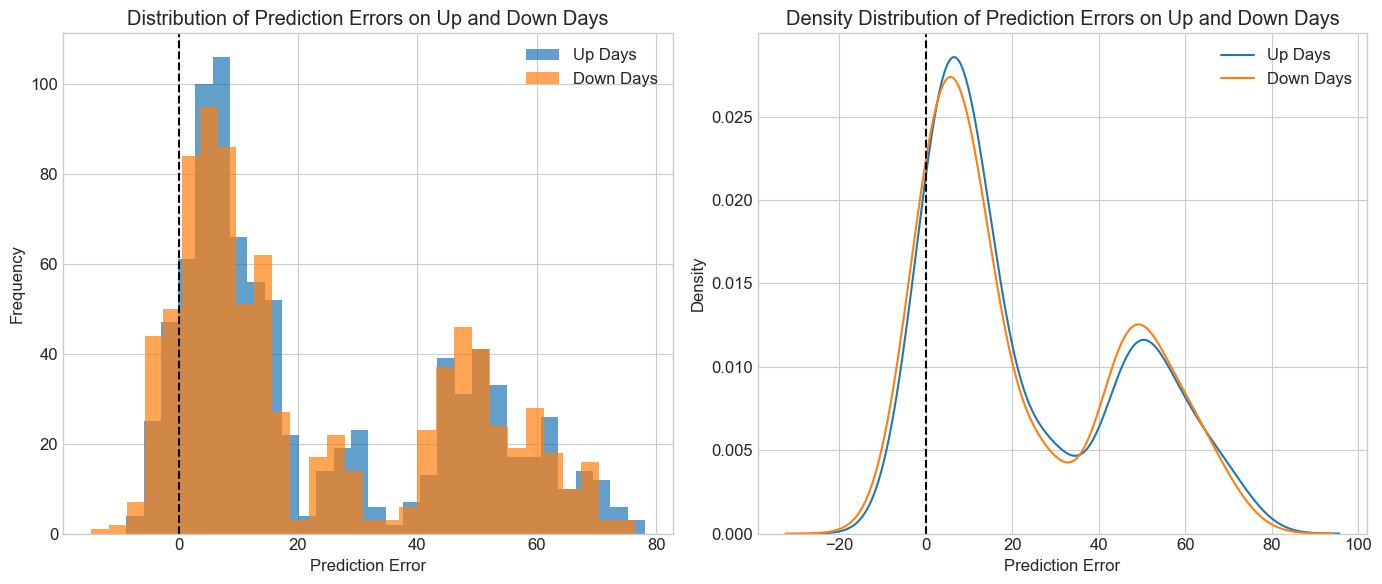


===== 方向性予測の精度 =====
方向性の予測精度: 48.46%


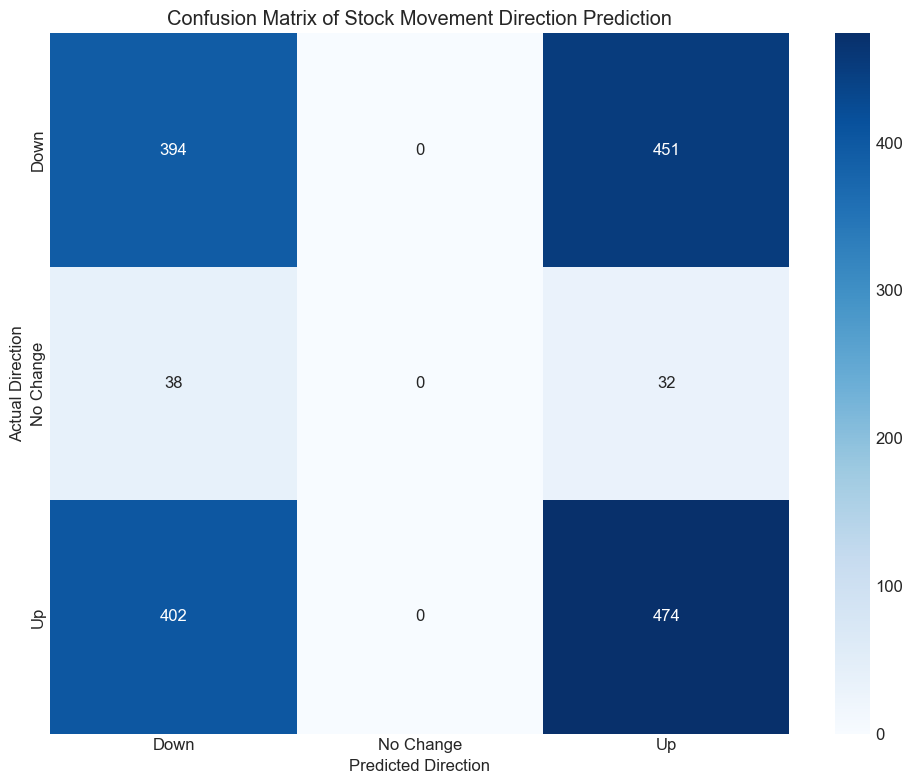

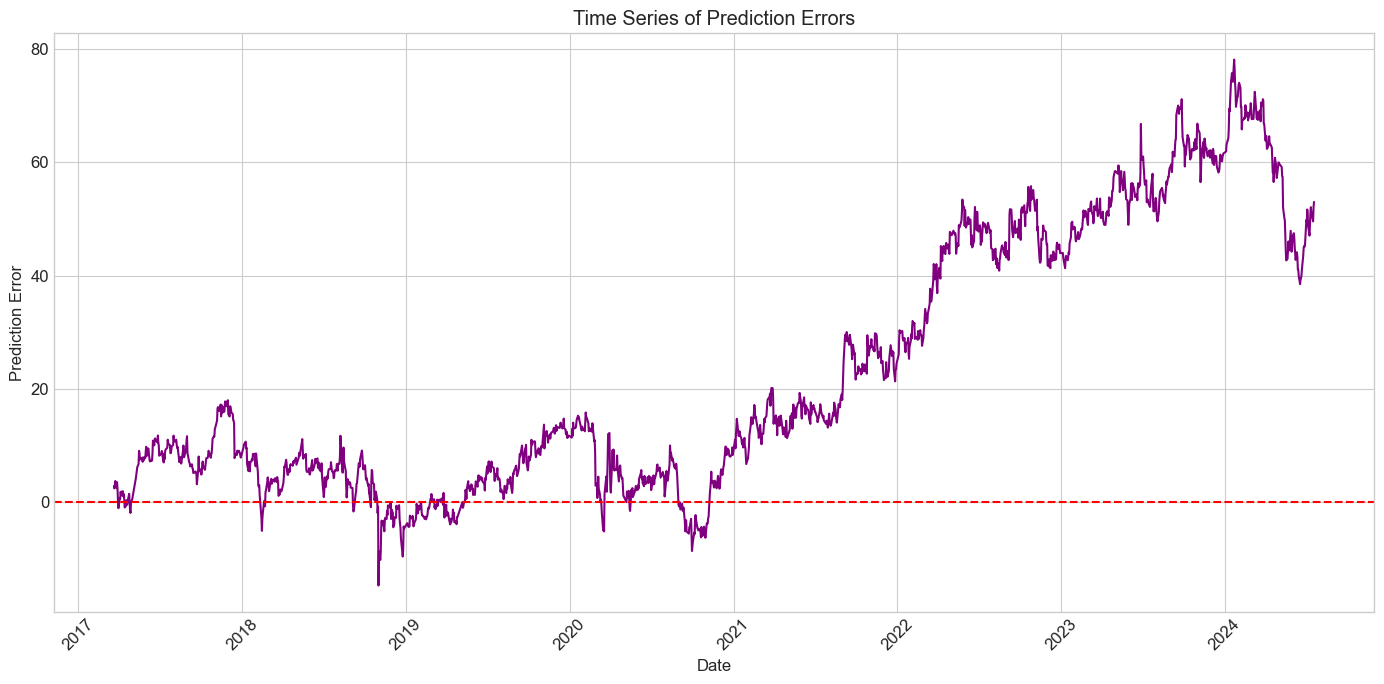

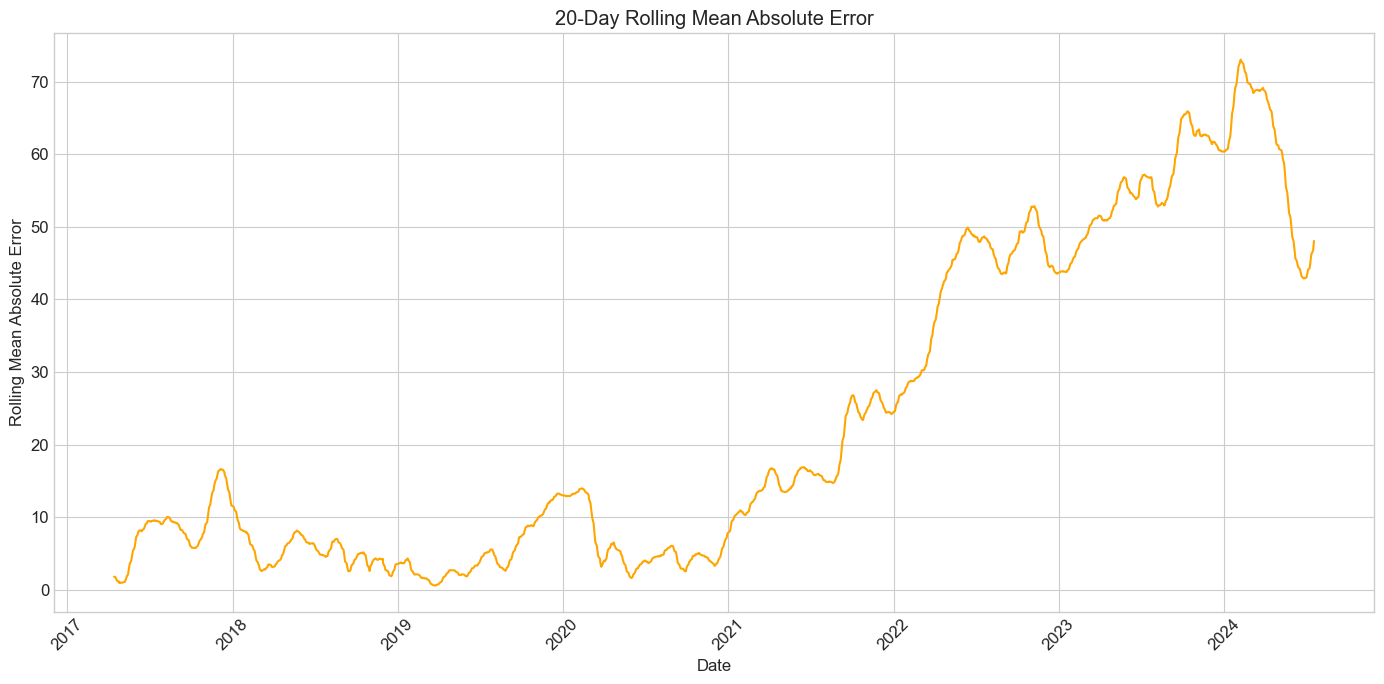

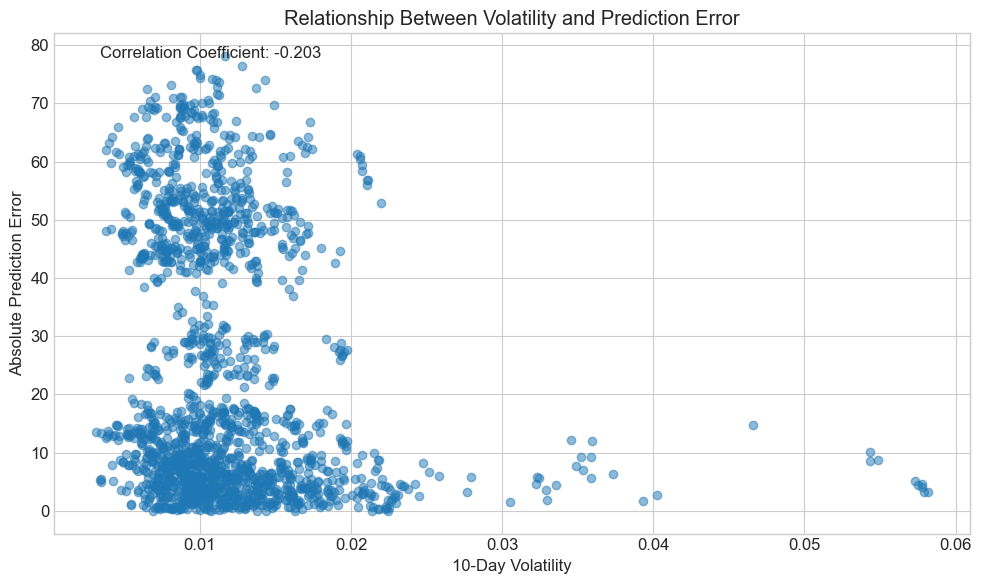


===== モデル総合評価 =====
全体の予測精度:
 RMSE: 32.28
 MAE: 23.53
 MAPE: 16.13%
 R²: -0.2963
方向性予測精度: 48.46%
上昇日の予測RMSE: 32.25
下降日の予測RMSE: 32.03
予測誤差と株価変動の相関: 0.130

モデルの強み:
- 株価変動と予測誤差の相関が低い (相関係数: 0.13)
- 下降トレンドの予測精度が高い

モデルの弱み:
- 方向性予測の精度が低い (48.5%)
- 全体的な予測精度に改善の余地がある (MAPE: 16.13%)

改善提案:
- より長期間のデータを使用して学習する
- 外部要因（市場指標、ニュースセンチメント等）を特徴量として追加する
- ハイパーパラメータのチューニングを行う
- アンサンブル手法を検討する


In [49]:
# テストデータの日付を取得
test_dates = df['Date'].iloc[-len(y_test):].reset_index(drop=True)

# 1. 実際の株価と予測株価の時系列可視化
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test, label='Actual Stock Price', color='blue')
plt.plot(test_dates, y_pred, label='Predicted Stock Price', color='red', linestyle='--')
plt.title('Stock Price Prediction Using LSTM Model')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 予測値と実際の値の散布図
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Stock Price')
plt.ylabel('Predicted Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. 予測誤差の分析
errors = y_test - y_pred
abs_errors = np.abs(errors)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(errors)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Density Distribution of Prediction Errors')
plt.xlabel('Prediction Error')

plt.tight_layout()
plt.show()


# 4. 株価変動と予測誤差の関係分析
price_changes = np.abs(np.diff(y_test))
error_magnitudes = np.abs(errors[1:])

plt.figure(figsize=(10, 6))
plt.scatter(price_changes, error_magnitudes, alpha=0.5)
plt.title('Relationship Between Stock Price Changes and Prediction Errors')
plt.xlabel('Magnitude of Stock Price Change')
plt.ylabel('Magnitude of Prediction Error')
plt.grid(True)


# 相関係数を計算
correlation = np.corrcoef(price_changes, error_magnitudes)[0, 1]
plt.annotate(f'Correlation Coefficient: {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.tight_layout()
plt.show()


# 5. トレンド別の予測精度分析
# 上昇日と下降日を分類
up_days = np.where(np.diff(y_test) > 0)[0] + 1
down_days = np.where(np.diff(y_test) < 0)[0] + 1

# 上昇日と下降日の予測誤差を計算
up_errors = errors[up_days]
down_errors = errors[down_days]

# 上昇日と下降日の予測誤差の二乗を計算
up_errors_squared = up_errors**2
down_errors_squared = down_errors**2

# 上昇日と下降日の予測誤差の統計量
print("\n===== トレンド別の予測精度 =====")
print("上昇日の予測誤差:")
print(f"件数: {len(up_errors)}")
print(f"平均: {np.mean(up_errors):.2f}")
print(f"標準偏差: {np.std(up_errors):.2f}")
print(f"RMSE: {np.sqrt(np.mean(up_errors_squared)):.2f}")

print("\n下降日の予測誤差:")
print(f"件数: {len(down_errors)}")
print(f"平均: {np.mean(down_errors):.2f}")
print(f"標準偏差: {np.std(down_errors):.2f}")
print(f"RMSE: {np.sqrt(np.mean(down_errors_squared)):.2f}")

# 上昇日と下降日の予測誤差の分布を可視化
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(up_errors, bins=30, alpha=0.7, label='Up Days')
plt.hist(down_errors, bins=30, alpha=0.7, label='Down Days')
plt.axvline(x=0, color='k', linestyle='--')
plt.title('Distribution of Prediction Errors on Up and Down Days')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(up_errors, label='Up Days')
sns.kdeplot(down_errors, label='Down Days')
plt.axvline(x=0, color='k', linestyle='--')
plt.title('Density Distribution of Prediction Errors on Up and Down Days')
plt.xlabel('Prediction Error')
plt.legend()

plt.tight_layout()
plt.show()


# 6. 方向性予測の精度評価
# 実際の株価の方向
actual_direction = np.sign(np.diff(y_test))

# 予測の方向
pred_direction = np.sign(np.diff(y_pred))

# 方向性の一致率
direction_accuracy = np.mean(actual_direction == pred_direction) * 100
print("\n===== 方向性予測の精度 =====")
print(f"方向性の予測精度: {direction_accuracy:.2f}%")

# 混同行列
cm = confusion_matrix(actual_direction, pred_direction)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Down', 'No Change', 'Up'],
           yticklabels=['Down', 'No Change', 'Up'])
plt.title('Confusion Matrix of Stock Movement Direction Prediction')
plt.xlabel('Predicted Direction')
plt.ylabel('Actual Direction')
plt.tight_layout()
plt.show()


# 7. 予測誤差の時系列分析
plt.figure(figsize=(14, 7))
plt.plot(test_dates[1:], errors[1:], color='purple')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Time Series of Prediction Errors')
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 8. 移動平均誤差の分析
window_size = 20
rolling_mae = pd.Series(abs_errors).rolling(window=window_size).mean()

plt.figure(figsize=(14, 7))
plt.plot(test_dates, rolling_mae, color='orange')
plt.title(f'{window_size}-Day Rolling Mean Absolute Error')
plt.xlabel('Date')
plt.ylabel('Rolling Mean Absolute Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 9. 予測精度のボラティリティ依存性分析
if 'Volatility_10d' in df.columns:
    volatility = df['Volatility_10d'].iloc[-len(y_test):].values

    plt.figure(figsize=(10, 6))
    plt.scatter(volatility, abs_errors, alpha=0.5)
    plt.title('Relationship Between Volatility and Prediction Error')
    plt.xlabel('10-Day Volatility')
    plt.ylabel('Absolute Prediction Error')
    plt.grid(True)

    # Calculate correlation coefficient
    vol_error_corr = np.corrcoef(volatility, abs_errors)[0, 1]
    plt.annotate(f'Correlation Coefficient: {vol_error_corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
    plt.tight_layout()
    plt.show()


# 10. 総合評価レポート
print("\n===== モデル総合評価 =====")
print(f"全体の予測精度:")
print(f" RMSE: {rmse:.2f}")
print(f" MAE: {mae:.2f}")
print(f" MAPE: {mape:.2f}%")
print(f" R²: {r2:.4f}")
print(f"方向性予測精度: {direction_accuracy:.2f}%")
print(f"上昇日の予測RMSE: {np.sqrt(np.mean(up_errors_squared)):.2f}")
print(f"下降日の予測RMSE: {np.sqrt(np.mean(down_errors_squared)):.2f}")
print(f"予測誤差と株価変動の相関: {correlation:.3f}")

# モデルの特性まとめ
strengths = []
weaknesses = []

if direction_accuracy > 55:
    strengths.append(f"方向性予測の精度が高い ({direction_accuracy:.1f}%)")
else:
    weaknesses.append(f"方向性予測の精度が低い ({direction_accuracy:.1f}%)")

if correlation > 0.5:
    weaknesses.append(f"株価変動が大きい時に予測誤差も大きくなる傾向がある (相関係数: {correlation:.2f})")
else:
    strengths.append(f"株価変動と予測誤差の相関が低い (相関係数: {correlation:.2f})")

if np.sqrt(np.mean(up_errors_squared)) < np.sqrt(np.mean(down_errors_squared)):
    strengths.append("上昇トレンドの予測精度が高い")
else:
    strengths.append("下降トレンドの予測精度が高い")

if mape < 5:
    strengths.append(f"全体的な予測精度が高い (MAPE: {mape:.2f}%)")
elif mape > 10:
    weaknesses.append(f"全体的な予測精度に改善の余地がある (MAPE: {mape:.2f}%)")

print("\nモデルの強み:")
for s in strengths:
    print(f"- {s}")

print("\nモデルの弱み:")
for w in weaknesses:
    print(f"- {w}")

print("\n改善提案:")
print("- より長期間のデータを使用して学習する")
print("- 外部要因（市場指標、ニュースセンチメント等）を特徴量として追加する")
print("- ハイパーパラメータのチューニングを行う")
print("- アンサンブル手法を検討する")